In [ ]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import os
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark") # Theme for plots as Dark
# sns.set_palette("viridis")
sns.color_palette("flare")
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold, RepeatedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import QuantileTransformer
import optuna
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from catboost import Pool, CatBoostRegressor, cv


In [ ]:
%pip install catboost
%pip install optuna
%pip install imblearn
%pip install optiver2023
%pip install seaborn

### 1. Load

In [4]:
train_data_orig = pd.read_csv("data/optiver-trading-at-the-close/train.csv")
test_data = pd.read_csv("data/optiver-trading-at-the-close/example_test_files/test.csv")
test_target = pd.read_csv("data/optiver-trading-at-the-close/example_test_files/revealed_targets.csv")
sample_submission = pd.read_csv("data/optiver-trading-at-the-close/example_test_files/sample_submission.csv")
train_data = pd.read_csv("selected_features.csv")

train_data.head()

,stock_id,date_id,target,seconds_in_bucket,Quantile_bid_size,Quantile_ask_size,spread,ask_ref_ratio,ask_wap_diff,imbalance_buy_sell_flag_1
0,0,0,-3.029704,0,0.739395,-0.635130,0.000214,1.000214,0.000026,True
1,1,0,-5.519986,0,-1.068202,-0.076523,0.000764,1.000764,0.000660,False
2,2,0,-8.389950,0,0.391064,-0.133653,0.000895,1.000737,0.000298,False
3,3,0,-4.010200,0,-1.200443,2.414491,0.000215,1.000043,0.000214,False
4,4,0,-7.349849,0,-0.196919,-1.885052,0.000622,1.000484,0.000016,False


In [3]:
# def Preprocess1(data):
#     data.set_index("row_id",inplace=True)
#     data.drop(['far_price', 'near_price','time_id'], axis = 1,inplace=True)
    
#     quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
#     data['Quantile_bid_size'] = quantile_transformer.fit_transform(data['bid_size'].values.reshape(-1, 1)).flatten()
#     data['Quantile_ask_size'] = quantile_transformer.fit_transform(data['ask_size'].values.reshape(-1, 1)).flatten()
    
#     data.drop(['bid_size', 'ask_size'], axis = 1,inplace=True)

#     return data


# # train_data = Preprocess1(train_data)

### 2. Split data

In [4]:

y = train_data['target']
X = train_data.drop(['target'], axis = 1)
#X = X.drop(['time_id'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21)

seed = np.random.seed(6)

### 3. Models
3.1  XGB Model


In [5]:
xgb = XGBRegressor(n_estimators = 100,tree_method="gpu_hist")
print("CV score of XGB is ",-1*cross_val_score(xgb,X,y,cv=3, scoring = 'neg_mean_absolute_error').mean())

CV score of XGB is  6.383920228866604



3.2 CatBoost Model


In [6]:
cat = CatBoostRegressor(n_estimators = 50,verbose=50)
print("CV score of CAT is ",-1*cross_val_score(cat,X,y,cv=3, scoring = 'neg_mean_absolute_error').mean())

Learning rate set to 0.5
0:	learn: 9.2991734	total: 284ms	remaining: 13.9s
49:	learn: 9.1962334	total: 6.68s	remaining: 0us
Learning rate set to 0.5
0:	learn: 9.3601420	total: 137ms	remaining: 6.73s
49:	learn: 9.2459499	total: 6.6s	remaining: 0us
Learning rate set to 0.5
0:	learn: 9.4808568	total: 132ms	remaining: 6.44s
49:	learn: 9.3700166	total: 6.75s	remaining: 0us
CV score of CAT is  6.33901905699913



3.3 LGBM Model


In [7]:
lgbm = LGBMRegressor(n_estimators = 100, verbose=0, force_col_wise=True, device="gpu")
print("CV score of LGBM is ",-1*cross_val_score(lgbm,X,y,cv=3, scoring = 'neg_mean_absolute_error').mean())

CV score of LGBM is  6.315784895718977



3.4 Optuna-Tuning XGB Model


In [ ]:
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators',100,500),
        'max_depth':  trial.suggest_int('max_depth',3,25),
        'min_child_weight': trial.suggest_float('min_child_weight', 2,50),
        "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.2,log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1),
        'gamma': trial.suggest_float("gamma", 1e-4, 1.0),
        "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
        "colsample_bylevel" : trial.suggest_float('colsample_bylevel',0.2,1),
        "colsample_bynode" : trial.suggest_float('colsample_bynode',0.2,1),
    }
    xgbmodel_optuna = XGBRegressor(**params,random_state=seed,tree_method = "gpu_hist")
    cv = -1*cross_val_score(xgbmodel_optuna, X, y, cv = 3,scoring='neg_mean_absolute_error').mean()
    return cv

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100,timeout=2000)

In [8]:
# 6.352538366942805
# n_estimators': 257, 'max_depth': 23, 'min_child_weight': 26.175847337987058, 
# 'learning_rate': 0.004077021052892053, 'subsample': 0.5526149569564831, 'gamma': 0.8266261989883712, 
# 'colsample_bytree': 0.7585071071985405, 'colsample_bylevel': 0.8825589806362955, 'colsample_bynode': 0.6780063157562866}
# xgb_params = {'max_depth': 20, 'min_child_weight': 25.551523309923255,
#               'learning_rate': 0.006449859500510082, 'subsample': 0.7408613470518393,
#               'gamma': 0.517595045309937, 'colsample_bytree': 0.25779788854085006,
#               'colsample_bylevel': 0.5934831570321946, 'colsample_bynode':  0.6780063157562866}
xgb_params = {'max_depth': 8, 'min_child_weight': 26.175847337987058,
              'learning_rate': 0.004077021052892053, 'subsample': 0.5526149569564831,
              'gamma': 0.8266261989883712, 'colsample_bytree': 0.7585071071985405,
              'colsample_bylevel': 0.8825589806362955, 'colsample_bynode': 0.5628928537973386}
xgb_opt = XGBRegressor(**xgb_params,n_estimators = 257,random_state=seed,tree_method = "gpu_hist")
print("CV score of Optuna XGB is ",-1*cross_val_score(xgb_opt,X,y,cv=3, scoring = 'neg_mean_absolute_error').mean())

CV score of Optuna XGB is  6.329306109347086



3.5 Optuna-Tuning LGBM Model


In [15]:
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators',100,1000),
        "max_depth":trial.suggest_int('max_depth',3,40),
        "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.25, log=True),
        "min_child_weight" : trial.suggest_float('min_child_weight', 0.5,4),
        "min_child_samples" : trial.suggest_int('min_child_samples',1,100),
        "subsample" : trial.suggest_float('subsample', 0.2, 1),
        "subsample_freq" : trial.suggest_int('subsample_freq',0,5),
        "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 128),
    }
    lgbmmodel_optuna = LGBMRegressor(**params,random_state=seed,device="gpu")
    cv = -1*cross_val_score(lgbmmodel_optuna, X, y, cv = 3,scoring='neg_mean_absolute_error').mean()
    return cv

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100,timeout=2000)

In [9]:
lgbm_params = {'max_depth': 36, 'learning_rate': 0.0105942655225861,
               'min_child_weight': 1.9489096317119756, 'min_child_samples': 66,
               'subsample': 0.34776401409168767, 'subsample_freq': 4,
               'colsample_bytree': 0.8255341076749996, 'num_leaves': 55}

lgbm_opt = LGBMRegressor(**lgbm_params, n_estimators = 208, device="gpu")
print("CV score of Optuna LGBM is ",-1*cross_val_score(lgbm_opt,X,y,cv=3, scoring = 'neg_mean_absolute_error').mean())

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1778
[LightGBM] [Info] Number of data points in the train set: 3491840, number of used features: 9
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (26.64 MB) transferred to GPU in 0.032087 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.032471
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (9.28 MB) transferred to GPU in 0.014167 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (9.27 MB) transferred to GPU in 0.015522 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature gr


3.6 Time-Series Split 4-Fold EarlyStopping


In [10]:
SPLITS = 4
cat_score = []
models = []

for i,(tr,val) in enumerate(TimeSeriesSplit(n_splits=SPLITS,test_size=1000000).split(X,y)):
    
    print("-"*30,f"FOLD {i+1}/{SPLITS}","-"*30)
    X_train, X_test, y_train, y_test = X.iloc[tr,:],X.iloc[val,:],y.iloc[tr],y.iloc[val]
    print("Train Dataset:",len(X_train),"Test Dataset:",len(X_test))
    train_dataset = Pool(data=X.iloc[tr,:],label=y.iloc[tr])
    eval_dataset = Pool(data=X.iloc[val,:],label=y.iloc[val])
    catmodel = CatBoostRegressor(iterations=2000,verbose=250, od_type="Iter",eval_metric="MAE", random_seed=seed,early_stopping_rounds=250,learning_rate=0.085)
    catmodel.fit(train_dataset, use_best_model=True, eval_set=eval_dataset)
    mae = mean_absolute_error(y.iloc[val], catmodel.predict(X.iloc[val,:]))
    cat_score.append(mae)
    if mae<7:
        models.append(catmodel)
    
print("\n\n","-"*50,sep="")
print("CV score of CAT is ",np.array(cat_score).mean())

------------------------------ FOLD 1/4 ------------------------------
Train Dataset: 1237760 Test Dataset: 1000000
0:	learn: 5.9286200	test: 7.4377717	best: 7.4377717 (0)	total: 55ms	remaining: 1m 49s
250:	learn: 5.7842781	test: 7.3167152	best: 7.3083628 (156)	total: 12.3s	remaining: 1m 25s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 7.308362777
bestIteration = 156

Shrink model to first 157 iterations.
------------------------------ FOLD 2/4 ------------------------------
Train Dataset: 2237760 Test Dataset: 1000000
0:	learn: 6.6040198	test: 6.2270729	best: 6.2270729 (0)	total: 90.9ms	remaining: 3m 1s
250:	learn: 6.4545578	test: 6.1756406	best: 6.1643112 (47)	total: 21.6s	remaining: 2m 30s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 6.164311249
bestIteration = 47

Shrink model to first 48 iterations.
------------------------------ FOLD 3/4 ------------------------------
Train Dataset: 3237760 Test Dataset: 1000000
0:	learn: 6.4876728	test

In [57]:
cat_score

[7.308363777970951, 6.164312249715543, 6.405510239053915, 5.94546949080953]


3.4 Evaluating OOF 4-Fold CatBoost 

In [11]:
sub = pd.DataFrame()
sub["index"] = X_test.index
sub["preds"] = 0

for i,model in enumerate(models):
    print(f"> Getting preds from Model{i+1}")
    sub["preds"] += model.predict(X_test)

sub["preds"] = sub["preds"]/len(models)    

> Getting preds from Model1
> Getting preds from Model2
> Getting preds from Model3


In [12]:
mae = mean_absolute_error(y_test, sub["preds"])
print(f"MAE of merged predictions: {mae}")

MAE of merged predictions: 5.955815377876551


In [13]:
xgb_opt.fit(X,y)
lgbm_opt.fit(X,y)
models.extend([xgb_opt,lgbm_opt])
len(models)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1781
[LightGBM] [Info] Number of data points in the train set: 5237760, number of used features: 9
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (39.96 MB) transferred to GPU in 0.054496 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.047589
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (13.91 MB) transferred to GPU in 0.020918 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (13.90 MB) transferred to GPU in 0.020761 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature 

5

3.5 Predictions on Example dataset


In [35]:
test_data=pd.read_csv("data/optiver-trading-at-the-close/example_test_files/test.csv")
test_data = Preprocess1(test_data)
test_data.drop(['time_id'], axis = 1,inplace=True)
test_data.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap
row_id,,,,,,,,,,,,
478_0_0,0,478,0,3753451.43,-1,0.999875,11548975.43,0.999875,22940.00,1.000050,9177.60,1.0
478_0_1,1,478,0,985977.11,-1,1.000245,3850033.97,0.999940,1967.90,1.000601,19692.00,1.0
478_0_2,2,478,0,599128.74,1,1.000584,4359198.25,0.999918,4488.22,1.000636,34955.12,1.0
478_0_3,3,478,0,2872317.54,-1,0.999802,27129551.64,0.999705,16082.04,1.000189,10314.00,1.0
478_0_4,4,478,0,740059.14,-1,0.999886,8880890.78,0.999720,19012.35,1.000107,7245.60,1.0


In [36]:
from sklearn.preprocessing import QuantileTransformer

def quantile(df_train):
    quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
    df_train['Quantile_bid_size'] = quantile_transformer.fit_transform(df_train['bid_size'].values.reshape(-1, 1)).flatten()
    df_train['Quantile_ask_size'] = quantile_transformer.fit_transform(df_train['ask_size'].values.reshape(-1, 1)).flatten()

    return df_train
# original features
features = ['imbalance_size',  'bid_size', 'ask_size']
test_data=quantile(test_data)
# drop features
test_data = test_data.drop(features, axis=1)

In [37]:
test_data['ask_wap_diff'] = test_data['ask_price'] - test_data['wap']
test_data['ask_ref_ratio'] = test_data['ask_price']/test_data['reference_price']
test_data['spread'] = test_data['ask_price'] - test_data['bid_price']
dummy_cols_list = ['imbalance_buy_sell_flag']
dummy_names = []
for col in dummy_cols_list:
    dummy_df = pd.get_dummies(test_data.loc[:, col], prefix=col, drop_first=True)
    dummy_names += dummy_df.columns.tolist()
    # drop original column
    test_data = test_data.drop(col, axis=1)
    test_data = pd.concat([test_data, dummy_df], axis=1)

test_data.drop(['imbalance_buy_sell_flag_0'], axis = 1,inplace=True)

In [42]:
#keep only train_data columns
test_data = test_data[X.columns]

In [43]:
test_data.head()

,stock_id,date_id,seconds_in_bucket,Quantile_bid_size,Quantile_ask_size,spread,ask_ref_ratio,ask_wap_diff,imbalance_buy_sell_flag_1
row_id,,,,,,,,,
478_0_0,0,478,0,-0.169291,-0.828134,0.000175,1.000175,0.000050,False
478_0_1,1,478,0,-1.421929,-0.379171,0.000661,1.000356,0.000601,False
478_0_2,2,478,0,-1.066162,0.052739,0.000718,1.000052,0.000636,True
478_0_3,3,478,0,-0.407908,-0.767809,0.000484,1.000387,0.000189,False
478_0_4,4,478,0,-0.294946,-0.956933,0.000387,1.000221,0.000107,False


In [44]:
test_target.head()

,stock_id,date_id,seconds_in_bucket,time_id,revealed_target,revealed_date_id,revealed_time_id
0,0.0,478,0,26290,-2.310276,477.0,26235.0
1,1.0,478,0,26290,-12.850165,477.0,26235.0
2,2.0,478,0,26290,-0.439882,477.0,26235.0
3,3.0,478,0,26290,7.259846,477.0,26235.0
4,4.0,478,0,26290,4.780292,477.0,26235.0


In [72]:
#add baseline catboost
cat.fit(X,y)
models.append(cat)

Learning rate set to 0.5
0:	learn: 9.3805966	total: 249ms	remaining: 12.2s
49:	learn: 9.2821365	total: 10s	remaining: 0us


In [73]:
models

 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8825589806362955,
              colsample_bynode=0.5628928537973386,
              colsample_bytree=0.7585071071985405, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.8266261989883712,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.004077021052892053,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=26.175847337987058, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=257,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...),
 LGBMRegressor(colsample_bytree=0.8255341076749996, device='gpu',
               learning_rate=0.0105942655225861, max_depth=36,
  

In [74]:
#all models predictions
y_sample_pred = pd.DataFrame()
y_sample_pred["index"] =  test_data.index
y_sample_pred["preds"] = 0

for i,model in enumerate(models):
    print(f"> Getting preds from Model{i+1}")
    y_sample_pred["preds"] += model.predict(test_data)

y_sample_pred["preds"] = y_sample_pred["preds"]/len(models)    

y_sample_true = test_target['revealed_target'].dropna()

> Getting preds from Model1
> Getting preds from Model2
> Getting preds from Model3
> Getting preds from Model4
> Getting preds from Model5
> Getting preds from Model6


In [68]:
models[3]

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8825589806362955,
             colsample_bynode=0.5628928537973386,
             colsample_bytree=0.7585071071985405, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.8266261989883712,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.004077021052892053,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=26.175847337987058, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=257,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [69]:
models[4]

LGBMRegressor(colsample_bytree=0.8255341076749996, device='gpu',
              learning_rate=0.0105942655225861, max_depth=36,
              min_child_samples=66, min_child_weight=1.9489096317119756,
              n_estimators=208, num_leaves=55, subsample=0.34776401409168767,
              subsample_freq=4)

In [62]:
#xgb model prediction
y_sample_pred_xgb = pd.DataFrame()
y_sample_pred_xgb["index"] =  test_data.index
y_sample_pred_xgb["preds"] = 0

model = models[3]
y_sample_pred_xgb["preds"] += model.predict(test_data)



In [63]:
y_sample_pred_xgb

,index,preds
0,478_0_0,-0.563518
1,478_0_1,1.174319
2,478_0_2,1.625217
3,478_0_3,-0.478536
4,478_0_4,-0.673921
...,...,...
32995,480_540_195,-0.175569
32996,480_540_196,-0.356622
32997,480_540_197,-0.078589
32998,480_540_198,0.611552


In [77]:
# save the submission
y_sample_pred_xgb.to_csv("submission_xgb.csv",index=False)
y_sample_pred.to_csv("submission_avg.csv",index=False)

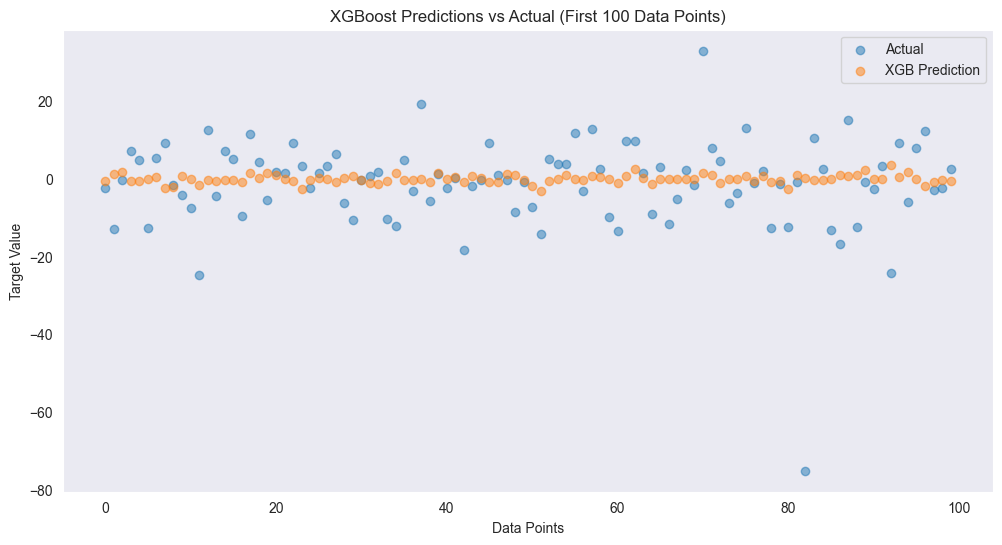

In [65]:

pred_xgb=y_sample_pred_xgb["preds"]
# visualize xgb
num_points = 100

# Plotting the XGBoost predictions
plt.figure(figsize=(12, 6))

plt.scatter(np.arange(num_points), y_sample_true[:num_points], label='Actual', alpha=0.5)
plt.scatter(np.arange(num_points), pred_xgb[:num_points], label='XGB Prediction', alpha=0.5)
plt.title('XGBoost Predictions vs Actual (First 100 Data Points)')
plt.xlabel('Data Points')
plt.ylabel('Target Value')
plt.legend()



In [51]:
pred = y_sample_pred["preds"]
pred

0       -0.736357
1        1.680921
2        2.471652
3       -0.834323
4       -0.939124
           ...   
32995   -0.459129
32996   -0.827403
32997   -0.304256
32998    1.439210
32999   -0.982023
Name: preds, Length: 33000, dtype: float64

In [75]:
mae_test = mean_absolute_error(y_sample_pred["preds"], y_sample_true)
print(f"MAE on the test Dataset: {mae_test}")

# mae for all models
mae = []
for model in models:
    mae.append(mean_absolute_error(y_sample_true, model.predict(test_data)))

MAE on the test Dataset: 5.447127373927771


In [76]:
# mae for all models
mae

[5.490223371576237,
 5.4695367695742405,
 5.464299676051225,
 5.408351065939545,
 5.4392564314529785,
 5.477995655554476]

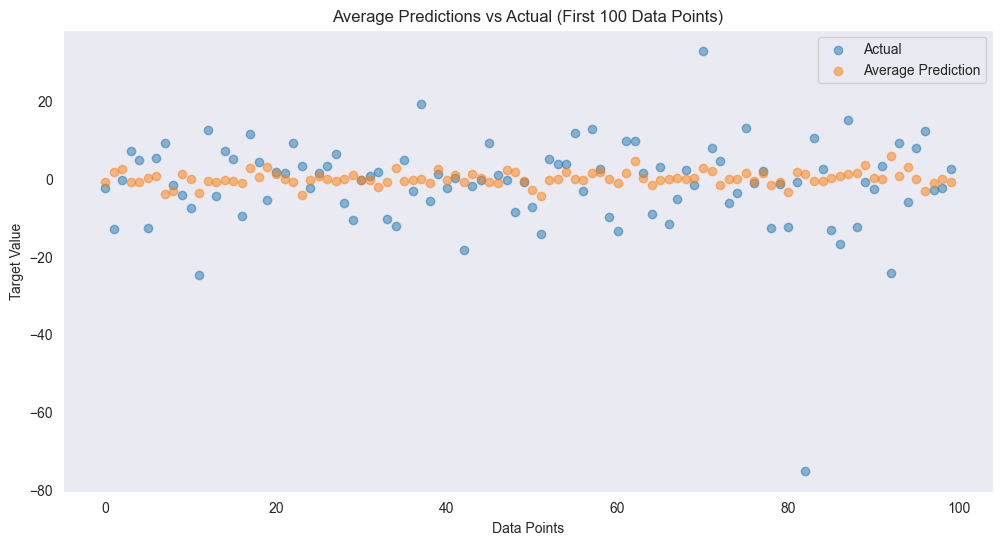

In [66]:
# Plot for the first 100 datapoints

num_points = 100

# Plotting the XGBoost predictions
plt.figure(figsize=(12, 6))

plt.scatter(np.arange(num_points), y_sample_true[:num_points], label='Actual', alpha=0.5)
plt.scatter(np.arange(num_points), pred[:num_points], label='Average Prediction', alpha=0.5)
plt.title('Average Predictions vs Actual (First 100 Data Points)')
plt.xlabel('Data Points')
plt.ylabel('Target Value')
plt.legend()

# null model

In [4]:
y_sample_true = test_target['revealed_target'].dropna()
y_sample_true.shape

(33000,)

In [7]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, mean_absolute_error
y_sample_pred = y_sample_true.copy()
# change all values to null
y_sample_pred[:] = 0
mae_test = mean_absolute_error(y_sample_pred, y_sample_true)
print(f"MAE on the test Dataset with null values: {mae_test}")

MAE on the test Dataset with null values: 5.391541739227757


In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, mean_absolute_error
# change all values to ones
y_sample_pred[:] = 1
mae_test = mean_absolute_error(y_sample_pred, y_sample_true)
print(f"MAE on the test Dataset with 1 values: {mae_test}")

MAE on the test Dataset with 1 values: 5.488977390443515
